In [14]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

In [15]:
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
mobile = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in mobile.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(mobile.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization False
16 ReLU False
17 DepthwiseConv2D False
18 BatchNormalization False
19 ReLU False
20 Conv2D False
21 BatchNormalization False
22 ReLU False
23 ZeroPadding2D False
24 DepthwiseConv2D False
25 BatchNormalization False
26 ReLU False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 DepthwiseConv2D False
31 BatchNormalization False
32 ReLU False
33 Conv2D False
34 BatchNormalization False
35 ReLU False
36 ZeroPadding2D False
37 DepthwiseConv2D False
38 BatchNormalization False
39 ReLU False
40 Conv2D False
41 BatchNormalization False
42 ReLU False
43 DepthwiseConv2D False
44 BatchNormalization False
45 ReLU False
46 Conv2D False
47 BatchNormalization False
48

In [16]:
def addTopModel(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model=GlobalAveragePooling2D()(top_model)
    top_model=Dense(1024,activation='relu')(top_model) 
    top_model=Dense(1024,activation='relu')(top_model) 
    top_model=Dense(512,activation='relu')(top_model) 
    top_model = Dense(num_classes, activation = "softmax")(top_model)

    return top_model

In [17]:
num_classes = 4

FC_Head = addTopModel(mobile, num_classes)

model = Model(inputs=mobile.input, outputs=FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [18]:
train_data_dir = r'D:\OCT20\train'
validation_data_dir = r'D:\OCT20\test'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
batch_size=16
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 8000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [20]:
checkpoint = ModelCheckpoint("retinal_mobile1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [21]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

In [22]:
nb_train_samples = 8000
nb_validation_samples = 1000

epochs = 10
batch_size = 16

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
500/500 [==============================] - 375s 735ms/step - loss: 0.7663 - accuracy: 0.7013 - val_loss: 0.4313 - val_accuracy: 0.8427

Epoch 00001: val_loss improved from inf to 0.43127, saving model to retinal_mobile1.h5
Epoch 2/10
500/500 [==============================] - 237s 474ms/step - loss: 0.4936 - accuracy: 0.8202 - val_loss: 0.1560 - val_accuracy: 0.9496

Epoch 00002: val_loss improved from 0.43127 to 0.15599, saving model to retinal_mobile1.h5
Epoch 3/10
500/500 [==============================] - 238s 475ms/step - loss: 0.3873 - accuracy: 0.8506 - val_loss: 0.2839 - val_accuracy: 0.9073

Epoch 00003: val_loss did not improve from 0.15599
Epoch 4/10
500/500 [==============================] - 236s 472ms/step - loss: 0.3662 - accuracy: 0.8708 - val_loss: 0.1774 - val_accuracy: 0.9355

Epoch 00004: val_loss did not improve from 0.15599
Epoch 5/10
500/500 [==============================] - 233s 465ms/step - loss: 0.3238 - accuracy: 0.8838 - val_loss: 0.1678 - val_acc

In [24]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


63/63 [==============================] - 19s 303ms/step - loss: 0.1554 - accuracy: 0.9500

Test result: 95.000 loss: 0.155


In [25]:
model.save("retinal_mobile.h5")

In [26]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1000 images belonging to 4 classes.


In [27]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [28]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [29]:
y_pred_label = np.argmax(y_pred, axis=1)

In [30]:
validation_generator.classes.shape,y_pred_label.shape

((1000,), (1000,))

In [31]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Confusion Matrix
[[237   1  12   0]
 [  7 228   9   6]
 [  8   3 239   0]
 [  0   0   4 246]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.94      0.95      0.94       250
         DME       0.98      0.91      0.95       250
      DRUSEN       0.91      0.96      0.93       250
      NORMAL       0.98      0.98      0.98       250

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



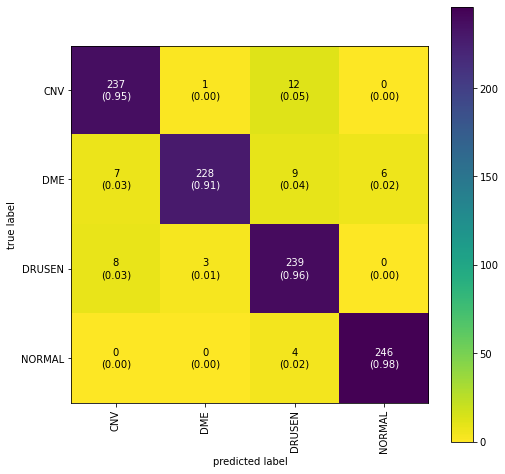

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
cnf_matrix=confusion_matrix(validation_generator.classes, y_pred_label)
plot_confusion_matrix(conf_mat=cnf_matrix,figsize=(8,8),show_normed=True)# show norm face si normalizarea
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

color_map = plt.imshow(cnf_matrix)
color_map.set_cmap('viridis_r')
plt.colorbar()

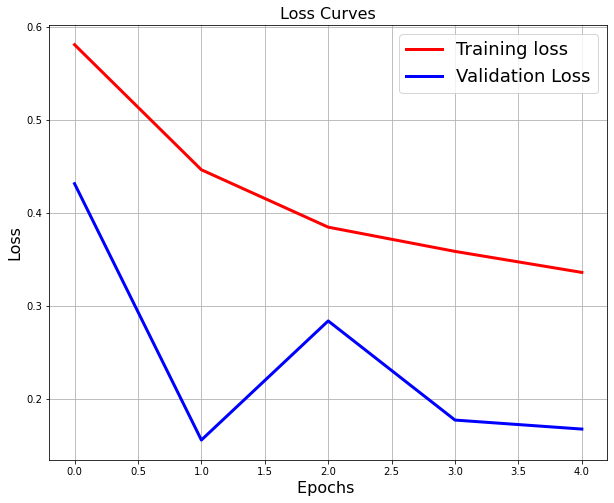

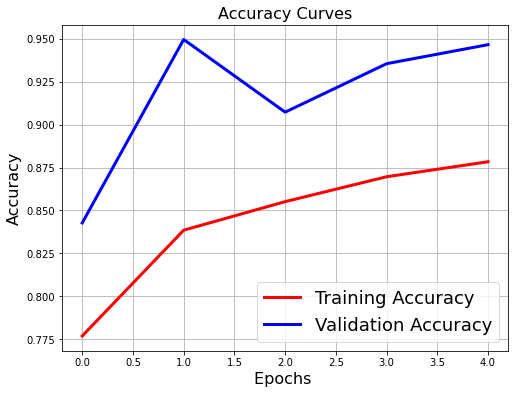

In [33]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
#plt.plot(history.history['acc'],'r',linewidth=3.0)
#plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);